# OWL Win Predictor Data Processing

In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import datetime
import pickle
from joblib import dump, load 
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
import math

In [78]:
# Calculate different number of combinations
combos_top5 = 0
for i in range(8,13):
    combos =  math.factorial(32)/ (math.factorial(i) * math.factorial(32-i))
    combos_top5 = combos_top5 + combos
combos_top5

457896660.0

In [79]:
# 2020 ruleset
tanks =  math.factorial(8)/ (math.factorial(2) * math.factorial(6))
dps = math.factorial(17)/ (math.factorial(2) * math.factorial(15))
support = math.factorial(7)/ (math.factorial(2) * math.factorial(5))

total_combos_no_swaps = tanks * dps * support
total_combos_no_swaps

79968.0

## Reading in player data

In [80]:
# map(function,iterable) -> read csv in each phs folder and assign to one dataframe
player_stats_all = pd.concat(map(pd.read_csv, glob.glob('datasets/phs*/*.csv')))
player_stats_all.head()

,start_time,match_id,stage,map_type,map_name,player,team,stat_name,hero,stat_amount,pelstart_time
0,7/12/2018 0:19,13121,Overwatch League Inaugural Season Championship,PAYLOAD,Dorado,Gamsu,Boston Uprising,All Damage Done,All Heroes,10677.179340,NaN
1,7/12/2018 0:19,13121,Overwatch League Inaugural Season Championship,PAYLOAD,Dorado,Gamsu,Boston Uprising,Assists,All Heroes,10.000000,NaN
2,7/12/2018 0:19,13121,Overwatch League Inaugural Season Championship,PAYLOAD,Dorado,Gamsu,Boston Uprising,Average Time Alive,All Heroes,60.004185,NaN
3,7/12/2018 0:19,13121,Overwatch League Inaugural Season Championship,PAYLOAD,Dorado,Gamsu,Boston Uprising,Barrier Damage Done,All Heroes,4868.578228,NaN
4,7/12/2018 0:19,13121,Overwatch League Inaugural Season Championship,PAYLOAD,Dorado,Gamsu,Boston Uprising,Damage - Quick Melee,All Heroes,304.000000,NaN


In [81]:
# Drops mystery column - none of the files had this column. I don't know where it came from. 
player_stats_all.drop(["pelstart_time"], axis = 1, inplace = True)

# Resets index and drops the new row it makes
player_stats_all.reset_index(drop = True, inplace = True)
player_stats_all

,start_time,match_id,stage,map_type,map_name,player,team,stat_name,hero,stat_amount
0,7/12/2018 0:19,13121,Overwatch League Inaugural Season Championship,PAYLOAD,Dorado,Gamsu,Boston Uprising,All Damage Done,All Heroes,10677.179340
1,7/12/2018 0:19,13121,Overwatch League Inaugural Season Championship,PAYLOAD,Dorado,Gamsu,Boston Uprising,Assists,All Heroes,10.000000
2,7/12/2018 0:19,13121,Overwatch League Inaugural Season Championship,PAYLOAD,Dorado,Gamsu,Boston Uprising,Average Time Alive,All Heroes,60.004185
3,7/12/2018 0:19,13121,Overwatch League Inaugural Season Championship,PAYLOAD,Dorado,Gamsu,Boston Uprising,Barrier Damage Done,All Heroes,4868.578228
4,7/12/2018 0:19,13121,Overwatch League Inaugural Season Championship,PAYLOAD,Dorado,Gamsu,Boston Uprising,Damage - Quick Melee,All Heroes,304.000000
...,...,...,...,...,...,...,...,...,...,...
3906348,10/10/2020 15:21,35552,OWL 2020 Regular Season,HYBRID,Hollywood,tobi,Seoul Dynasty,Ultimates Earned - Fractional,Mercy,4.811592
3906349,10/10/2020 15:21,35552,OWL 2020 Regular Season,HYBRID,Hollywood,tobi,Seoul Dynasty,Ultimates Used,Mercy,4.000000
3906350,10/10/2020 15:21,35552,OWL 2020 Regular Season,HYBRID,Hollywood,tobi,Seoul Dynasty,Valkyrie Healing Efficiency,Mercy,301.680441
3906351,10/10/2020 15:21,35552,OWL 2020 Regular Season,HYBRID,Hollywood,tobi,Seoul Dynasty,Weapon Accuracy,Mercy,0.368421


In [82]:
# Creates a year column and converts round_start_time to a datetime object, then extracts the year
player_stats_all['year'] = pd.to_datetime(player_stats_all['start_time'])
player_stats_all['year'] = pd.DatetimeIndex(player_stats_all["year"]).year

In [83]:
# Drops columns I will not be using
player_stats_all.drop(["start_time","stage", "map_type","stat_name", "stat_amount"], inplace = True, axis = 1)
player_stats_all = player_stats_all[player_stats_all.hero != "All Heroes"]

# sorts by match_id in ascending order and resets the index
player_stats_all = player_stats_all.sort_values(by = ["match_id", "map_name", "team" ], ascending = True)

#drops duplicate rows
player_stats_all = player_stats_all.drop_duplicates(subset = ["match_id", "map_name", "team", "hero"])

player_stats_all.reset_index(drop = True, inplace = True)
player_stats_all

,match_id,map_name,player,team,hero,year
0,10223,Dorado,Agilities,Los Angeles Valiant,Genji,2018.0
1,10223,Dorado,Envy,Los Angeles Valiant,D.Va,2018.0
2,10223,Dorado,Fate,Los Angeles Valiant,Winston,2018.0
3,10223,Dorado,KariV,Los Angeles Valiant,Mercy,2018.0
4,10223,Dorado,SoOn,Los Angeles Valiant,Tracer,2018.0
...,...,...,...,...,...,...
80977,35554,Temple of Anubis,Marve1,Seoul Dynasty,Sigma,2020.0
80978,35554,Temple of Anubis,Profit,Seoul Dynasty,Genji,2020.0
80979,35554,Temple of Anubis,Profit,Seoul Dynasty,Hanzo,2020.0
80980,35554,Temple of Anubis,Profit,Seoul Dynasty,Pharah,2020.0


## Read in map data

In [84]:
map_stats = pd.read_csv("datasets\match_map_stats.csv")

# Add the year column
map_stats['year'] = pd.to_datetime(map_stats['round_start_time'])
map_stats['year'] = pd.DatetimeIndex(map_stats["year"]).year

In [85]:
# filters down to needed columns and drops duplicate maps per match_id
map_stats = map_stats.filter(["match_id", "match_winner", "map_winner", "map_loser", "map_name","year"], axis = 1)
map_stats = map_stats.drop_duplicates(subset = ["match_id", "map_name"])

## Merge player stats and map stats

In [86]:
# Merges map stats and player stats with an outer join on the keys match_id, map_name, and year.
merge_all = pd.merge(map_stats, player_stats_all, how = "outer", on = ["match_id", "map_name", "year"])

# Sorts the values by match_id, map_name, and team
merge_all = merge_all.sort_values(by = ["match_id", "map_name", "team" ], ascending = True)

# Creates a match_win and map_win column. 
# It compares the team on the each row to the declareed winner from the map stat files.
# I made them strings so the categories were clear on the classifiers.
 
merge_all.loc[merge_all["match_winner"] == merge_all["team"], 'match_win'] = "win"
merge_all.loc[merge_all["match_winner"] != merge_all["team"], 'match_win'] = "lose"

merge_all.loc[merge_all["map_winner"] == merge_all["team"], 'map_win'] = "win"
merge_all.loc[merge_all["map_winner"] != merge_all["team"], 'map_win'] = "lose"

# Filters to only the listes columns.
merge_all = merge_all.filter(["match_id", "map_name","player", "team", "hero", "match_win" , "map_win", "year"])

# Drops rows without complete data. There was incomplete data on certain hero usage in games, 
# and there is no real way to find out without reviewing the match.
merge_all.dropna(axis = 0, how = 'any', inplace = True)

# Prints to csv with index removed
merge_all.to_csv("filteredData/all_merged_cat.csv", index = False)
merge_all

,match_id,map_name,player,team,hero,match_win,map_win,year
0,10223,Dorado,Agilities,Los Angeles Valiant,Genji,win,win,2018.0
1,10223,Dorado,Envy,Los Angeles Valiant,D.Va,win,win,2018.0
2,10223,Dorado,Fate,Los Angeles Valiant,Winston,win,win,2018.0
3,10223,Dorado,KariV,Los Angeles Valiant,Mercy,win,win,2018.0
4,10223,Dorado,SoOn,Los Angeles Valiant,Tracer,win,win,2018.0
...,...,...,...,...,...,...,...,...
74688,35554,Temple of Anubis,Marve1,Seoul Dynasty,Sigma,win,win,2020.0
74689,35554,Temple of Anubis,Profit,Seoul Dynasty,Genji,win,win,2020.0
74690,35554,Temple of Anubis,Profit,Seoul Dynasty,Hanzo,win,win,2020.0
74691,35554,Temple of Anubis,Profit,Seoul Dynasty,Pharah,win,win,2020.0


### Split hero data by year

In [87]:
stats_2018 = merge_all[merge_all['year'] == 2018]
sorted_2018 = stats_2018.sort_values(by = 'hero')

stats_2019 = merge_all[merge_all['year'] == 2019]
sorted_2019 = stats_2019.sort_values(by = 'hero')

stats_2020 = merge_all[merge_all['year'] == 2020]
sorted_2020 = stats_2020.sort_values(by = 'hero')

merge_all_hero_sort = merge_all.copy()
merge_all_hero_sort = merge_all_hero_sort.sort_values(by = 'hero' )

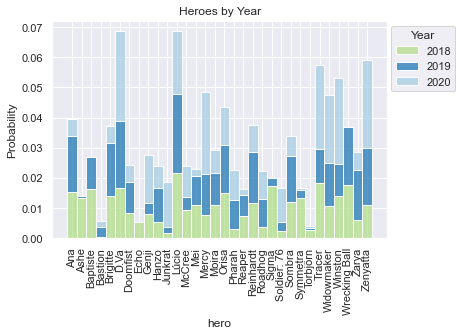

In [88]:
# Creates a histogram with probability for each character. 
# Data is the dataset used, hue selects the categories for the legend, multiple selects how the bars aligned.
# Check seaborn documentation for more information.

hero_freq = sns.histplot(
    data = merge_all_hero_sort,
    x = "hero",
    hue = "year",
    multiple = "stack",
    stat = "probability",
    palette="Paired",
    legend = True
)
sns.set(style = "darkgrid")
hero_freq.set_title("Heroes by Year")
hero_freq.legend(title = "Year", loc = "upper right", labels = ["2018", "2019","2020"], bbox_to_anchor= (1.22, 1))
plt.xticks(rotation = 90)
hero_freq.figure.savefig("plots/hero_probability_by_year_stacked.png", dpi = 300, bbox_inches = "tight")
plt.show()

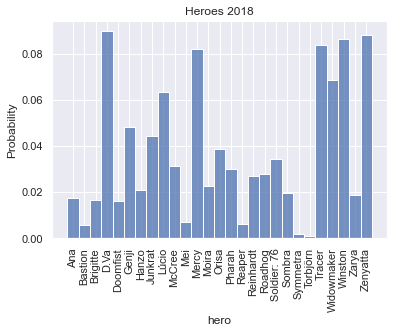

In [89]:
hero_2018 = sns.histplot(
    data = sorted_2018,
    x = "hero",
    stat = "probability",
)

hero_2018.set_title("Heroes 2018")
sns.set(style = "darkgrid")
plt.xticks(rotation = 90)
hero_2018.figure.savefig("plots/hero2018.png", dpi = 300, bbox_inches = "tight")
plt.show()

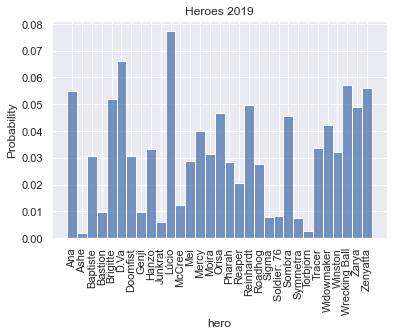

In [90]:
hero_2019 = sns.histplot(
    data = sorted_2019,
    x = "hero",
    stat = "probability",
    element = "bars"
)

hero_2019.set_title("Heroes 2019")
sns.set(style = "darkgrid")
plt.xticks(rotation = 90)
hero_2019.figure.savefig("plots/hero2019.png", dpi = 300, bbox_inches = "tight")
plt.show()

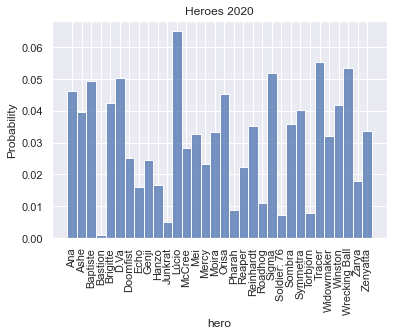

In [91]:
hero_2020 = sns.histplot(
    data = sorted_2020,
    x = "hero",
    stat = "probability",
    element = "bars"
)
hero_2020.set_title("Heroes 2020")
sns.set(style = "darkgrid")
plt.xticks(rotation = 90)
hero_2020.figure.savefig("plots/hero2020.png", dpi = 300, bbox_inches = "tight")
plt.show()

In [92]:
# Ensure everything is grouped properly and save it to a CSV

grouped = merge_all.groupby(["match_id", "map_name","team","player","hero", "map_win", "match_win", "year"]).count()
grouped.to_csv("filteredData/grouped.csv")

In [93]:
# Reads the previously saved CSV and converts it to a list of lists
data = pd.read_csv("filteredData/grouped.csv")
dataList = data.values.tolist()
dataList[0]

[10223,
 'Dorado',
 'Los Angeles Valiant',
 'Agilities',
 'Genji',
 'win',
 'win',
 2018.0]

## Create Data Frame for Team Compositions as Lists

In [94]:
# Creates a new DF with column titles
comps = pd.DataFrame(columns = ['match_id',"map_name",'team_name','team_comp','match_win','map_win', 'year'])
comps

,match_id,map_name,team_name,team_comp,match_win,map_win,year


In [95]:
# Convert dataList into dataframe which contains lists for team compositions
# Indices - [0 = match_id, 1 = map, 2 = teamName, 3 = Player Name, 4 = Hero, 5 = match_win, 6 = map_win, 7 = year]

match_id = dataList[0][0]

map_name = dataList[0][1]
team_name = dataList[0][2]

team_comp= [dataList[0][4]]
match_winner = dataList[0][5]
map_winner = dataList[0][6]
year = dataList[0][7]

# Gets the previous line and current line.
# Checks if the match_id, map, and teams match.
# If they do match, append the hero to the team comp list
# Else, the team has changed, and we want to append the data for the previous 
# composition to the dataframe.

for i in range(1,len(dataList)):
    prevLine = dataList[i-1]
    line = dataList[i]

    if(prevLine[0] == line[0] and prevLine[1] == line[1] and prevLine[2] == line[2]):
        team_comp.append(line[4]) 
    else:
        #sort alphabetically
        team_comp = sorted(team_comp)

        #create a dictionary entry for the team
        df2 = {"match_id" : match_id, "map_name": map_name ,"team_name": team_name, "team_comp" : team_comp, "match_win": match_winner, "map_win" : map_winner, "year" : year}

        #append it to the dataframe
        comps = comps.append(df2, ignore_index = True)

        #reset values to the current line
        match_id = line[0]
        map_name = line[1]
        team_name = line[2]
        team_comp = [line[4]]
        match_winner = line[5]
        map_winner = line[6]
        year = line[7]

In [96]:
# Saves the dataframe as a joblib file (object serialization)
# Many dataframes are saved and loaded for use multiple times in their original format.

dump(comps, "dataframes/teamCompsDF.joblib")
comps

,match_id,map_name,team_name,team_comp,match_win,map_win,year
0,10223,Dorado,Los Angeles Valiant,"[D.Va, Genji, Mercy, Tracer, Widowmaker, Winst...",win,win,2018.0
1,10223,Dorado,San Francisco Shock,"[D.Va, Genji, Junkrat, McCree, Mercy, Tracer, ...",lose,lose,2018.0
2,10223,Ilios,Los Angeles Valiant,"[D.Va, Genji, Lúcio, McCree, Mercy, Pharah, So...",win,win,2018.0
3,10223,Ilios,San Francisco Shock,"[D.Va, Lúcio, McCree, Mercy, Pharah, Soldier: ...",lose,lose,2018.0
4,10223,Numbani,Los Angeles Valiant,"[Bastion, D.Va, Lúcio, Mercy, Soldier: 76, Tra...",win,win,2018.0
...,...,...,...,...,...,...,...
6578,35554,Busan,Philadelphia Fusion,"[Ashe, D.Va, Lúcio, Mercy, Sigma, Symmetra, Tr...",lose,lose,2020.0
6579,35554,Busan,Seoul Dynasty,"[Ana, Ashe, Mercy, Roadhog, Sigma, Sombra, Sym...",win,win,2020.0
6580,35554,King's Row,Philadelphia Fusion,"[Ana, Hanzo, Lúcio, Mercy, Moira, Roadhog, Sig...",lose,lose,2020.0
6581,35554,King's Row,Seoul Dynasty,"[Ana, Hanzo, Lúcio, Mercy, Roadhog, Sigma, Sym...",win,win,2020.0


## Create a "target vector" that's going to be passed into the encoder.

The results for each map are based off of "team 1", so I use both teams as "team1" to give the classifers another vector to train with. Therefore "targetVectors" DF contains two entries for each round. The "singleTargetVector" does not swap team1 and only has 1 entry for each round.

In [97]:
comps.to_csv("comps_list.csv", index = False)
compsList = comps.values.tolist()

targetVectors = pd.DataFrame(columns = ['match_id','team1_comp', 'team2_comp','match_win','map_win'])
targetVectors

,match_id,team1_comp,team2_comp,match_win,map_win


In [98]:
singleTargetVector = pd.DataFrame(columns = ['match_id','team1_comp', 'team2_comp','match_win','map_win'])

In [99]:
# Gets current and next row, converts info into dictionary form to append to DF
for i in range(0, len(compsList)-1, 2):
    row1 = compsList[i]
    row2 = compsList[i+1]

    tv1 = {'match_id' : row1[0], 'team1_comp' : row1[3], 'team2_comp': row2[3], 'match_win': row1[4], 'map_win' : row1[5]}
    tv2 = {'match_id' : row1[0], 'team1_comp' : row2[3], 'team2_comp': row1[3],  'match_win': row2[4], 'map_win' : row2[5]}

    targetVectors = targetVectors.append(tv1, ignore_index= True)
    targetVectors = targetVectors.append(tv2, ignore_index = True)
    singleTargetVector = singleTargetVector.append(tv1, ignore_index = True)

targetVectors

,match_id,team1_comp,team2_comp,match_win,map_win
0,10223,"[D.Va, Genji, Mercy, Tracer, Widowmaker, Winst...","[D.Va, Genji, Junkrat, McCree, Mercy, Tracer, ...",win,win
1,10223,"[D.Va, Genji, Junkrat, McCree, Mercy, Tracer, ...","[D.Va, Genji, Mercy, Tracer, Widowmaker, Winst...",lose,lose
2,10223,"[D.Va, Genji, Lúcio, McCree, Mercy, Pharah, So...","[D.Va, Lúcio, McCree, Mercy, Pharah, Soldier: ...",win,win
3,10223,"[D.Va, Lúcio, McCree, Mercy, Pharah, Soldier: ...","[D.Va, Genji, Lúcio, McCree, Mercy, Pharah, So...",lose,lose
4,10223,"[Bastion, D.Va, Lúcio, Mercy, Soldier: 76, Tra...","[Ana, D.Va, Genji, McCree, Mercy, Soldier: 76,...",win,win
...,...,...,...,...,...
6577,35553,"[Ana, Ashe, Hanzo, Lúcio, Mercy, Roadhog, Sigm...","[Ana, Ashe, D.Va, Hanzo, Mercy, Pharah, Reinha...",win,lose
6578,35554,"[Ashe, D.Va, Lúcio, Mercy, Sigma, Symmetra, Tr...","[Ana, Ashe, Mercy, Roadhog, Sigma, Sombra, Sym...",lose,lose
6579,35554,"[Ana, Ashe, Mercy, Roadhog, Sigma, Sombra, Sym...","[Ashe, D.Va, Lúcio, Mercy, Sigma, Symmetra, Tr...",win,win
6580,35554,"[Ana, Hanzo, Lúcio, Mercy, Moira, Roadhog, Sig...","[Ana, Hanzo, Lúcio, Mercy, Roadhog, Sigma, Sym...",lose,lose


In [100]:
dump(targetVectors, "dataframes/double.joblib")

['dataframes/double.joblib']

In [101]:
singleTargetVector
dump(singleTargetVector, "dataframes/single.joblib")

['dataframes/single.joblib']

In [102]:
# Creates a data frame for team and map without composition

teamWins = pd.DataFrame(columns = ['match_id', 'map', 'team1', 'team2','match_win','map_win'])
for i in range(0, len(compsList)-1, 2):
    row1 = compsList[i]
    row2 = compsList[i+1]

    tv1 = {'match_id' : row1[0], 'map' : row1[1] , 'team1' : row1[2], 'team2': row2[2], 'match_win': row1[4], 'map_win' : row1[5]}
    tv2 = {'match_id' : row1[0], 'map' : row2[1],'team1' : row2[2], 'team2': row1[2],  'match_win': row2[4], 'map_win' : row2[5]}

    teamWins = teamWins.append(tv1, ignore_index= True)
    teamWins = teamWins.append(tv2, ignore_index = True)

teamWins["map_result"] = np.where(teamWins["map_win"] == 'win', 1 , 0)
dump(teamWins, "dataframes/teamWins.joblib")
teamWins

,match_id,map,team1,team2,match_win,map_win,map_result
0,10223,Dorado,Los Angeles Valiant,San Francisco Shock,win,win,1
1,10223,Dorado,San Francisco Shock,Los Angeles Valiant,lose,lose,0
2,10223,Ilios,Los Angeles Valiant,San Francisco Shock,win,win,1
3,10223,Ilios,San Francisco Shock,Los Angeles Valiant,lose,lose,0
4,10223,Numbani,Los Angeles Valiant,San Francisco Shock,win,win,1
...,...,...,...,...,...,...,...
6577,35553,Volskaya Industries,Shanghai Dragons,Seoul Dynasty,win,lose,0
6578,35554,Busan,Philadelphia Fusion,Seoul Dynasty,lose,lose,0
6579,35554,Busan,Seoul Dynasty,Philadelphia Fusion,win,win,1
6580,35554,King's Row,Philadelphia Fusion,Seoul Dynasty,lose,lose,0


In [103]:
# Creates a target vector for team comp and map for encoder
TVMaps = pd.DataFrame(columns = ['match_id', 'map', 'team1_comp', 'team2_comp','match_win','map_win'])
for i in range(0, len(compsList)-1, 2):
    row1 = compsList[i]
    row2 = compsList[i+1]

    tv1 = {'match_id' : row1[0], 'map' : row1[1] ,'team1_comp' : row1[3], 'team2_comp': row2[3], 'match_win': row1[4], 'map_win' : row1[5]}
    tv2 = {'match_id' : row1[0], 'map' : row2[1],'team1_comp' : row2[3], 'team2_comp': row1[3],  'match_win': row2[4], 'map_win' : row2[5]}

    TVMaps = TVMaps.append(tv1, ignore_index= True)
    TVMaps = TVMaps.append(tv2, ignore_index = True)

dump(TVMaps, "dataframes/double_maps.joblib")
TVMaps

,match_id,map,team1_comp,team2_comp,match_win,map_win
0,10223,Dorado,"[D.Va, Genji, Mercy, Tracer, Widowmaker, Winst...","[D.Va, Genji, Junkrat, McCree, Mercy, Tracer, ...",win,win
1,10223,Dorado,"[D.Va, Genji, Junkrat, McCree, Mercy, Tracer, ...","[D.Va, Genji, Mercy, Tracer, Widowmaker, Winst...",lose,lose
2,10223,Ilios,"[D.Va, Genji, Lúcio, McCree, Mercy, Pharah, So...","[D.Va, Lúcio, McCree, Mercy, Pharah, Soldier: ...",win,win
3,10223,Ilios,"[D.Va, Lúcio, McCree, Mercy, Pharah, Soldier: ...","[D.Va, Genji, Lúcio, McCree, Mercy, Pharah, So...",lose,lose
4,10223,Numbani,"[Bastion, D.Va, Lúcio, Mercy, Soldier: 76, Tra...","[Ana, D.Va, Genji, McCree, Mercy, Soldier: 76,...",win,win
...,...,...,...,...,...,...
6577,35553,Volskaya Industries,"[Ana, Ashe, Hanzo, Lúcio, Mercy, Roadhog, Sigm...","[Ana, Ashe, D.Va, Hanzo, Mercy, Pharah, Reinha...",win,lose
6578,35554,Busan,"[Ashe, D.Va, Lúcio, Mercy, Sigma, Symmetra, Tr...","[Ana, Ashe, Mercy, Roadhog, Sigma, Sombra, Sym...",lose,lose
6579,35554,Busan,"[Ana, Ashe, Mercy, Roadhog, Sigma, Sombra, Sym...","[Ashe, D.Va, Lúcio, Mercy, Sigma, Symmetra, Tr...",win,win
6580,35554,King's Row,"[Ana, Hanzo, Lúcio, Mercy, Moira, Roadhog, Sig...","[Ana, Hanzo, Lúcio, Mercy, Roadhog, Sigma, Sym...",lose,lose


In [104]:
# Load a copy of the dataframe so I don't change the original.

teamWins = load("dataframes/teamWins.joblib")
teamWins.drop(["match_win", "map_win"], axis = 1, inplace = True)
teamWins.sort_values(by = ["team1", "team2"], inplace = True)

teamWins

,match_id,map,team1,team2,map_result
2582,21293,Busan,Atlanta Reign,Boston Uprising,0
2584,21293,Eichenwalde,Atlanta Reign,Boston Uprising,0
2586,21293,Lijiang Tower,Atlanta Reign,Boston Uprising,0
2588,21293,Temple of Anubis,Atlanta Reign,Boston Uprising,0
2590,21293,Watchpoint: Gibraltar,Atlanta Reign,Boston Uprising,0
...,...,...,...,...,...
5025,34211,Junkertown,Washington Justice,Vancouver Titans,1
5027,34211,Temple of Anubis,Washington Justice,Vancouver Titans,1
6435,35534,Numbani,Washington Justice,Vancouver Titans,1
6437,35534,Oasis,Washington Justice,Vancouver Titans,1


In [105]:
# Finds the total maps/game played
# If I were to do this again, I would probably make a function
# that accepts a dataframe and column names, since I do this mulitple times
# to caclulate winning percentages.  

team_win_percentage = load("dataframes/teamWins.joblib")

# The counts here and in the future tell me that if grouped by the given column,
# here's how many games/maps that occured.

counts = team_win_percentage.groupby(["team1"], as_index = False).count()
counts

,team1,match_id,map,team2,match_win,map_win,map_result
0,Atlanta Reign,219,219,219,219,219,219
1,Boston Uprising,382,382,382,382,382,382
2,Chengdu Hunters,200,200,200,200,200,200
3,Dallas Fuel,361,361,361,361,361,361
4,Florida Mayhem,370,370,370,370,370,370
5,Guangzhou Charge,212,212,212,212,212,212
6,Hangzhou Spark,224,224,224,224,224,224
7,Houston Outlaws,373,373,373,373,373,373
8,London Spitfire,413,413,413,413,413,413
9,Los Angeles Gladiators,415,415,415,415,415,415


In [106]:
# Find total games/maps won
team_win_percentage = team_win_percentage.groupby(["team1", "map_result"], as_index = False).count()
team_win_percentage = team_win_percentage[team_win_percentage["map_result"] == 1]
team_win_percentage

,team1,map_result,match_id,map,team2,match_win,map_win
1,Atlanta Reign,1,103,103,103,103,103
3,Boston Uprising,1,157,157,157,157,157
5,Chengdu Hunters,1,77,77,77,77,77
7,Dallas Fuel,1,117,117,117,117,117
9,Florida Mayhem,1,120,120,120,120,120
11,Guangzhou Charge,1,129,129,129,129,129
13,Hangzhou Spark,1,126,126,126,126,126
15,Houston Outlaws,1,144,144,144,144,144
17,London Spitfire,1,215,215,215,215,215
19,Los Angeles Gladiators,1,234,234,234,234,234


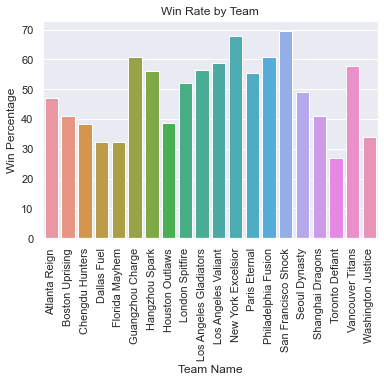

In [107]:
# Merge the two on team1 to find the win percentage
team_win_stats = pd.merge(team_win_percentage, counts, how = "left", on = ["team1"])
team_win_stats = team_win_stats.filter(["team1", "map_x", "map_y"])
team_win_stats["win_percentage"] = team_win_stats["map_x"] / team_win_stats["map_y"] * 100

team_wins = sns.barplot(
    data = team_win_stats,
    x = "team1",
    y = "win_percentage"
)

team_wins.set_title("Win Rate by Team")
team_wins.set(ylabel = "Win Percentage", xlabel = "Team Name")
team_wins.set_xticklabels(team_wins.get_xticklabels(), rotation = 90)
team_wins.figure.savefig("plots/team_winrate.png", dpi = 300, bbox_inches = "tight")
plt.show()

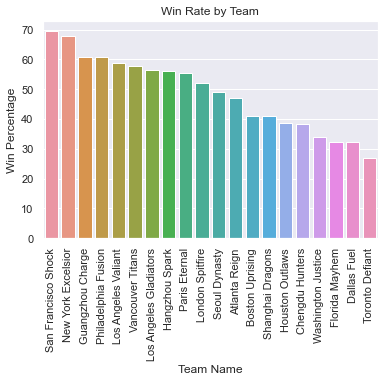

In [108]:
team_win_stats = team_win_stats.sort_values(by = "win_percentage", ascending = False)
team_wins = sns.barplot(
    data = team_win_stats,
    x = "team1",
    y = "win_percentage"
)
team_wins.set_title("Win Rate by Team")
team_wins.set(ylabel = "Win Percentage", xlabel = "Team Name")
team_wins.set_xticklabels(team_wins.get_xticklabels(), rotation = 90)
team_wins.figure.savefig("plots/team_winrate.png", dpi = 300, bbox_inches = "tight")
plt.show()

## Creating heat maps

In [109]:
# Creates a list of all the teams
team1 = teamWins["team1"].unique().tolist()
team1

['Atlanta Reign',
 'Boston Uprising',
 'Chengdu Hunters',
 'Dallas Fuel',
 'Florida Mayhem',
 'Guangzhou Charge',
 'Hangzhou Spark',
 'Houston Outlaws',
 'London Spitfire',
 'Los Angeles Gladiators',
 'Los Angeles Valiant',
 'New York Excelsior',
 'Paris Eternal',
 'Philadelphia Fusion',
 'San Francisco Shock',
 'Seoul Dynasty',
 'Shanghai Dragons',
 'Toronto Defiant',
 'Vancouver Titans',
 'Washington Justice']

In [110]:
team_maps = load("dataframes/teamWins.joblib")
team_maps = team_maps.filter(["team1", "team2", "map", "map_result"])
team_maps = team_maps.groupby(["team1", "map"], as_index = False).count()
team_maps

,team1,map,team2,map_result
0,Atlanta Reign,Blizzard World,7,7
1,Atlanta Reign,Busan,21,21
2,Atlanta Reign,Dorado,6,6
3,Atlanta Reign,Eichenwalde,9,9
4,Atlanta Reign,Hanamura,14,14
...,...,...,...,...
415,Washington Justice,Rialto,5,5
416,Washington Justice,Route 66,6,6
417,Washington Justice,Temple of Anubis,14,14
418,Washington Justice,Volskaya Industries,16,16


In [111]:
team_win_maps = load("dataframes/teamWins.joblib")
team_win_maps = team_win_maps.filter(["team1", "team2","map", "map_result"])
team_win_maps = team_win_maps.groupby(["team1", "map","map_result"], as_index = False).count()
team_win_maps = team_win_maps[team_win_maps["map_result"] ==  1]
team_win_maps

,team1,map,map_result,team2
1,Atlanta Reign,Blizzard World,1,4
3,Atlanta Reign,Busan,1,9
5,Atlanta Reign,Dorado,1,2
7,Atlanta Reign,Eichenwalde,1,5
9,Atlanta Reign,Hanamura,1,6
...,...,...,...,...
823,Washington Justice,Rialto,1,2
825,Washington Justice,Route 66,1,2
827,Washington Justice,Temple of Anubis,1,7
829,Washington Justice,Volskaya Industries,1,6


In [112]:
#merges the wins and total maps
team_win_stats = pd.merge(team_win_maps, team_maps, how = "left", on = ["team1", "map"] )
team_win_stats["map_winrate"] = team_win_stats["team2_x"]/team_win_stats["team2_y"] * 100
team_win_stats = team_win_stats.filter(["team1", "map", "map_winrate"])

#pivots teams stats so that team1 is the index and the columns are the map
team_win_stats = team_win_stats.pivot(index = "team1", columns= "map", values = "map_winrate")
team_win_stats = team_win_stats.fillna(0)
team_win_stats

map,Blizzard World,Busan,Dorado,Eichenwalde,Hanamura,Havana,Hollywood,Horizon Lunar Colony,Ilios,Junkertown,...,Lijiang Tower,Nepal,Numbani,Oasis,Paris,Rialto,Route 66,Temple of Anubis,Volskaya Industries,Watchpoint: Gibraltar
team1,,,,,,,,,,,,,,,,,,,,,
Atlanta Reign,57.142857,42.857143,33.333333,55.555556,42.857143,50.000000,40.000000,66.666667,40.000000,42.857143,...,58.333333,33.333333,40.000000,45.454545,25.000000,50.000000,66.666667,61.538462,33.333333,50.000000
Boston Uprising,57.894737,23.076923,44.444444,35.294118,23.076923,0.000000,23.076923,38.461538,54.166667,52.631579,...,43.750000,52.631579,56.250000,41.935484,0.000000,33.333333,62.500000,54.545455,60.000000,26.315789
Chengdu Hunters,42.857143,28.571429,42.857143,50.000000,40.000000,42.857143,27.272727,33.333333,38.461538,22.222222,...,37.500000,55.555556,37.500000,38.461538,22.222222,60.000000,33.333333,50.000000,41.666667,36.363636
Dallas Fuel,27.777778,27.272727,30.769231,60.000000,24.000000,28.571429,16.666667,40.000000,23.809524,16.666667,...,34.615385,26.315789,21.052632,48.000000,50.000000,57.142857,31.250000,27.272727,40.000000,34.782609
Florida Mayhem,36.363636,50.000000,21.428571,13.333333,44.444444,36.363636,43.750000,7.692308,40.740741,30.434783,...,25.000000,40.000000,31.578947,13.636364,40.000000,20.000000,43.750000,26.315789,34.782609,29.411765
Guangzhou Charge,66.666667,53.333333,75.000000,57.142857,75.000000,57.142857,58.333333,50.000000,78.571429,57.142857,...,47.058824,80.000000,50.000000,58.333333,12.500000,55.555556,40.000000,58.333333,84.615385,66.666667
Hangzhou Spark,66.666667,64.705882,44.444444,69.230769,45.454545,66.666667,50.000000,66.666667,66.666667,50.000000,...,53.333333,57.142857,62.500000,50.000000,62.500000,50.000000,62.500000,62.500000,42.857143,61.538462
Houston Outlaws,35.000000,33.333333,50.000000,43.750000,47.368421,57.142857,33.333333,64.285714,32.000000,27.777778,...,33.333333,38.095238,37.500000,39.285714,28.571429,44.444444,26.666667,36.842105,28.000000,47.368421
London Spitfire,47.619048,33.333333,76.190476,55.555556,62.500000,28.571429,58.333333,52.941176,43.333333,68.000000,...,58.064516,47.826087,55.000000,53.125000,50.000000,40.000000,50.000000,33.333333,52.173913,40.909091


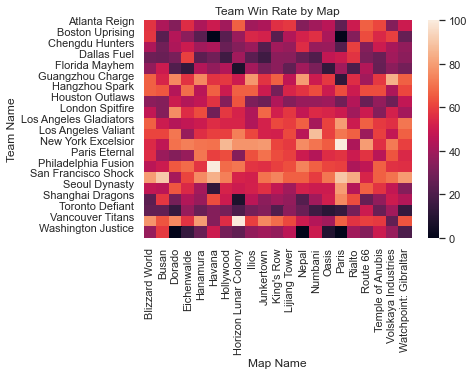

In [113]:
# Heat map for team1 per map
teamVmap = sns.heatmap(
    data = team_win_stats
)
teamVmap.set_title("Team Win Rate by Map")
teamVmap.set_yticks(range(0,20))
teamVmap.set_yticklabels(team1)
teamVmap.set_ylabel("Team Name")
teamVmap.set_xlabel("Map Name")
teamVmap.figure.savefig("plots/team_v_map_heatmap.png", dpi = 300, bbox_inches = "tight")
plt.show()

In [114]:
# Team vs team win rate 
team_wins = load("dataframes/teamWins.joblib")
team_wins = team_wins.sort_values(by = ["team1", "team2"])
team_wins = team_wins.filter(["team1", "team2", "map_result"])
team_wins = team_wins.groupby(["team1", "team2"], as_index = False).mean()
dump(team_wins, "dataframes/team_v_team.joblib")

# Pivot values to create matrix
team_wins_unsorted = team_wins.pivot(index = ["team1"], columns = ["team2"],  values = ["map_result"])
team_wins_unsorted = team_wins_unsorted.fillna(0)
team_wins_unsorted

map_result                                  \
team2                  Atlanta Reign Boston Uprising Chengdu Hunters   
team1                                                                  
Atlanta Reign               0.000000        0.750000        0.000000   
Boston Uprising             0.250000        0.000000        0.000000   
Chengdu Hunters             0.000000        1.000000        0.000000   
Dallas Fuel                 0.000000        0.380952        0.000000   
Florida Mayhem              0.666667        0.370370        0.000000   
Guangzhou Charge            1.000000        1.000000        0.896552   
Hangzhou Spark              0.500000        1.000000        0.888889   
Houston Outlaws             0.000000        0.583333        0.000000   
London Spitfire             0.500000        0.615385        0.352941   
Los Angeles Gladiators      1.000000        0.133333        1.000000   
Los Angeles Valiant         0.769231        0.517241        1.000000   
New York Excelsior          0.400000        0.678571        0.666667   
Paris Eternal               0.500000        0.736842        0.000000   
Philadelphia Fusion         1.000000        0.704545        0.000000   
San Francisco Shock         0.708333        0.761905        0.444444   
Seoul Dynasty               1.000000        0.333333        0.466667   
Shanghai Dragons            1.000000        0.000000        0.842105   
Toronto Defiant             0.277778        0.615385        0.000000   
Vancouver Titans            0.571429        1.000000        0.500000   
Washington Justice          0.000000        1.000000        0.000000   

                                                                    \
team2                  Dallas Fuel Florida Mayhem Guangzhou Charge   
team1                                                                
Atlanta Reign             1.000000       0.333333         0.000000   
Boston Uprising           0.619048       0.629630         0.000000   
Chengdu Hunters           1.000000       0.000000         0.103448   
Dallas Fuel               0.000000       0.380952         0.000000   
Florida Mayhem            0.619048       0.000000         0.000000   
Guangzhou Charge          1.000000       0.000000         0.000000   
Hangzhou Spark            1.000000       1.000000         0.357143   
Houston Outlaws           0.400000       0.636364         0.000000   
London Spitfire           0.750000       0.862069         0.333333   
Los Angeles Gladiators    0.741935       0.625000         1.000000   
Los Angeles Valiant       0.606061       0.882353         1.000000   
New York Excelsior        1.000000       1.000000         0.483871   
Paris Eternal             0.733333       0.727273         1.000000   
Philadelphia Fusion       0.826087       0.857143         0.000000   
San Francisco Shock       0.888889       0.838710         1.000000   
Seoul Dynasty             1.000000       1.000000         0.500000   
Shanghai Dragons          0.000000       0.235294         0.565217   
Toronto Defiant           0.000000       0.000000         0.000000   
Vancouver Titans          0.823529       0.363636         0.000000   
Washington Justice        0.166667       0.533333         0.000000   

                                                                       \
team2                  Hangzhou Spark Houston Outlaws London Spitfire   
team1                                                                   
Atlanta Reign                0.500000        1.000000        0.500000   
Boston Uprising              0.000000        0.416667        0.384615   
Chengdu Hunters              0.111111        1.000000        0.647059   
Dallas Fuel                  0.000000        0.600000        0.250000   
Florida Mayhem               0.000000        0.363636        0.137931   
Guangzhou Charge             0.642857        1.000000        0.666667   
Hangzhou Spark               0.000000        0.000000        0.769231   
Houston Outlaws             

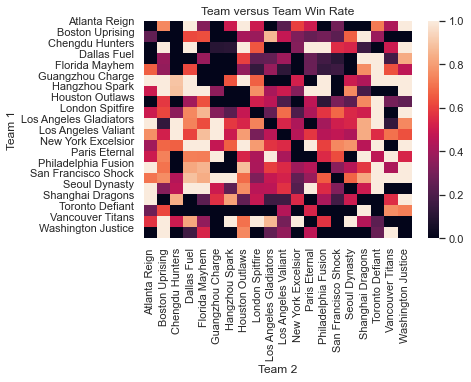

In [115]:
# Heat map team1 versus team2
heat_map = sns.heatmap(
    data = team_wins_unsorted
)
heat_map.set_title("Team versus Team Win Rate")
heat_map.set_yticks(range(0,20))
heat_map.set_yticklabels(team1)
heat_map.set_xticklabels(team1)
heat_map.set(ylabel = "Team 1", xlabel = "Team 2")
heat_map.figure.savefig("plots/team_v_team_heatmap.png", dpi = 300, bbox_inches = "tight")
plt.show()

## Start plotting by team composition

In [116]:
comps_tuple = load("dataframes/teamCompsDF.joblib")
comps_tuple['comp_size'] = comps_tuple['team_comp'].apply(lambda x: len(x))
comps_tuple['team_comp'] = comps_tuple['team_comp'].apply(lambda x: tuple(x))
dump(comps_tuple, "dataframes/comps_tuple.joblib")

# normal team size, no changes
comps_6 = comps_tuple[comps_tuple['comp_size'] == 6]

# one hero change
comps_7 = comps_tuple[comps_tuple['comp_size'] == 7]

In [117]:
comps_tuple.groupby(["team_comp"]).count()

,match_id,map_name,team_name,match_win,map_win,year,comp_size
team_comp,,,,,,,
"(Ana, Ashe, Baptiste, Bastion, Brigitte, D.Va, Doomfist, Echo, Lúcio, Moira, Orisa, Reaper, Reinhardt, Sigma, Symmetra, Tracer, Winston)",1,1,1,1,1,1,1
"(Ana, Ashe, Baptiste, Bastion, Brigitte, D.Va, Doomfist, Genji, Hanzo, Lúcio, Mercy, Orisa, Pharah, Reinhardt, Soldier: 76, Sombra, Tracer, Widowmaker, Winston, Wrecking Ball, Zarya)",1,1,1,1,1,1,1
"(Ana, Ashe, Baptiste, Bastion, Brigitte, D.Va, Doomfist, Hanzo, Lúcio, Mercy, Moira, Pharah, Reinhardt, Sombra, Torbjörn, Tracer, Widowmaker, Winston, Wrecking Ball, Zarya, Zenyatta)",1,1,1,1,1,1,1
"(Ana, Ashe, Baptiste, Bastion, Brigitte, D.Va, Genji, Hanzo, Lúcio, Mercy, Orisa, Pharah, Reinhardt, Sombra, Tracer, Widowmaker, Winston, Wrecking Ball, Zarya, Zenyatta)",1,1,1,1,1,1,1
"(Ana, Ashe, Baptiste, Bastion, Brigitte, D.Va, Junkrat, Lúcio, Mercy, Orisa, Pharah, Reinhardt, Sombra, Widowmaker, Wrecking Ball, Zarya, Zenyatta)",1,1,1,1,1,1,1
...,...,...,...,...,...,...,...
"(Lúcio, Moira, Reaper, Reinhardt, Sombra, Symmetra, Zarya)",3,3,3,3,3,3,3
"(Lúcio, Moira, Reaper, Reinhardt, Sombra, Widowmaker, Zarya)",1,1,1,1,1,1,1
"(Lúcio, Moira, Sombra, Symmetra, Tracer, Winston, Zarya)",1,1,1,1,1,1,1


In [118]:
# Changes single target vector lists to tuple
comp_v_comp = load("dataframes/single.joblib")
comp_v_comp['team1_comp'] = comp_v_comp['team1_comp'].apply(lambda x: tuple(x))
comp_v_comp['team2_comp'] = comp_v_comp['team2_comp'].apply(lambda x: tuple(x))

In [119]:
#Checks for mirror comps
mirror_comps = comp_v_comp[comp_v_comp['team1_comp'] == comp_v_comp['team2_comp']]
mirror_comps.drop(["match_win"], axis = 1)
mirror_comps["map_result"] = np.where(mirror_comps["map_win"] == 'win', 1 , 0)
mirror_comps

<ipython-input-119-b8dea582a2d6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mirror_comps["map_result"] = np.where(mirror_comps["map_win"] == 'win', 1 , 0)


,match_id,team1_comp,team2_comp,match_win,map_win,map_result
20,10227,"(D.Va, Lúcio, Mercy, Pharah, Tracer, Winston)","(D.Va, Lúcio, Mercy, Pharah, Tracer, Winston)",lose,lose,0
36,10231,"(Ana, D.Va, Mercy, Pharah, Soldier: 76, Tracer...","(Ana, D.Va, Mercy, Pharah, Soldier: 76, Tracer...",win,win,1
41,10233,"(D.Va, Lúcio, McCree, Mercy, Tracer, Widowmake...","(D.Va, Lúcio, McCree, Mercy, Tracer, Widowmake...",lose,lose,0
46,10234,"(D.Va, Lúcio, Mercy, Pharah, Soldier: 76, Trac...","(D.Va, Lúcio, Mercy, Pharah, Soldier: 76, Trac...",lose,lose,0
79,10242,"(D.Va, Lúcio, McCree, Mercy, Tracer, Widowmake...","(D.Va, Lúcio, McCree, Mercy, Tracer, Widowmake...",win,win,1
...,...,...,...,...,...,...
2874,34752,"(Ashe, Baptiste, Brigitte, Genji, Orisa, Sigma)","(Ashe, Baptiste, Brigitte, Genji, Orisa, Sigma)",win,win,1
2904,34762,"(Ana, Ashe, D.Va, Mercy, Sombra, Symmetra, Wid...","(Ana, Ashe, D.Va, Mercy, Sombra, Symmetra, Wid...",win,win,1
3104,34892,"(Ana, Brigitte, Genji, Sombra, Winston, Zarya)","(Ana, Brigitte, Genji, Sombra, Winston, Zarya)",lose,win,1
3259,35546,"(D.Va, Lúcio, Moira, Reaper, Sombra, Winston)","(D.Va, Lúcio, Moira, Reaper, Sombra, Winston)",win,win,1


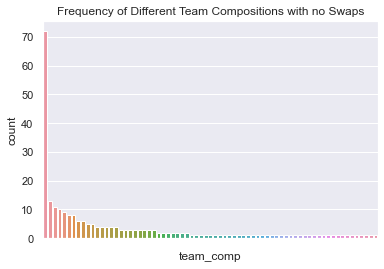

In [120]:
#Frequency of certain comps for no swaps
comp_plot = sns.countplot(
    x = "team_comp",
    data = comps_6,
    order = comps_6['team_comp'].value_counts().index
)
sns.set_style("darkgrid")
comp_plot.set_title("Frequency of Different Team Compositions with no Swaps")
comp_plot.set(xticklabels = [])
comp_plot.figure.savefig("plots/comp6_plot.png", dpi = 300, bbox_inches = "tight")
plt.show()

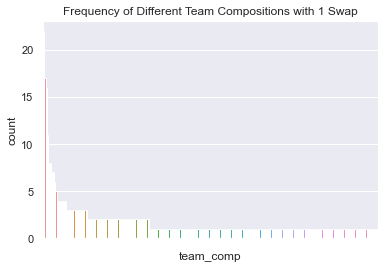

In [121]:
#Frequency of certain comps for no swaps
comp_plot = sns.countplot(
    x = "team_comp",
    data = comps_7,
    order = comps_7['team_comp'].value_counts().index
)
sns.set_style("darkgrid")
comp_plot.set_title("Frequency of Different Team Compositions with 1 Swap")
comp_plot.set(xticklabels = [])
comp_plot.figure.savefig("plots/comp7_plot.png", dpi = 300, bbox_inches = "tight")
plt.show()

In [122]:
comps_tuple.describe()
# Average comp size is 11, median is 11, so that means they swapped characters on average 5 times

,year,comp_size
count,6583.000000,6583.000000
mean,2019.009570,11.219353
std,0.826704,3.104316
min,2018.000000,6.000000
25%,2018.000000,9.000000
50%,2019.000000,11.000000
75%,2020.000000,13.000000
max,2020.000000,24.000000


In [123]:
# Checking if the median is the same as the mean or if data is skewed.
comps_tuple.median()

match_id     21382.0
year          2019.0
comp_size       11.0
dtype: float64

In [124]:
percentage = comps_tuple.groupby(["team_comp", "map_win"]).count()
percentage["usage_percent"] = percentage["match_id"]/comps_tuple["match_id"].count()*100

In [125]:
#Calculating how much each team is used
percentage.sort_values(by = ["usage_percent"], ascending = False)

# Divide the team comps counts to get frequency
percentage = comps_6.groupby(["team_comp"], as_index = False).count()
percentage["usage_percent"] = percentage["match_id"]/comps_6["match_id"].count()*100
percentage.sort_values(by = ["usage_percent"], ascending = False)

,team_comp,match_id,map_name,team_name,match_win,map_win,year,comp_size,usage_percent
43,"(Brigitte, D.Va, Lúcio, Reinhardt, Zarya, Zeny...",72,72,72,72,72,72,72,28.685259
69,"(Doomfist, Lúcio, Moira, Orisa, Reaper, Sigma)",13,13,13,13,13,13,13,5.179283
68,"(D.Va, Mercy, Tracer, Widowmaker, Winston, Zen...",11,11,11,11,11,11,11,4.382470
13,"(Ana, D.Va, Lúcio, McCree, Mei, Reinhardt)",10,10,10,10,10,10,10,3.984064
62,"(D.Va, Lúcio, Moira, Reaper, Sombra, Winston)",9,9,9,9,9,9,9,3.585657
...,...,...,...,...,...,...,...,...,...
36,"(Baptiste, Mei, Orisa, Roadhog, Widowmaker, Ze...",1,1,1,1,1,1,1,0.398406
37,"(Baptiste, Orisa, Sigma, Sombra, Widowmaker, Z...",1,1,1,1,1,1,1,0.398406
38,"(Baptiste, Orisa, Sigma, Tracer, Widowmaker, Z...",1,1,1,1,1,1,1,0.398406
39,"(Baptiste, Sigma, Tracer, Widowmaker, Wrecking...",1,1,1,1,1,1,1,0.398406


## Calculating win rate per team composition

I tried plotting this, but it takes a long time and does not look good, so I removed it.

In [126]:
maps_used = load("dataframes/comps_tuple.joblib")
maps_used = maps_used.groupby(["team_comp", "comp_size", "map_win"], as_index = False).count()
maps_used["num_maps"] = maps_used["match_id"]
maps_used = maps_used.filter(["team_comp", "map_win", "comp_size", "num_maps"])
maps_used

,team_comp,map_win,comp_size,num_maps
0,"(Ana, Ashe, Baptiste, Bastion, Brigitte, D.Va,...",lose,17,1
1,"(Ana, Ashe, Baptiste, Bastion, Brigitte, D.Va,...",lose,21,1
2,"(Ana, Ashe, Baptiste, Bastion, Brigitte, D.Va,...",win,21,1
3,"(Ana, Ashe, Baptiste, Bastion, Brigitte, D.Va,...",win,20,1
4,"(Ana, Ashe, Baptiste, Bastion, Brigitte, D.Va,...",lose,17,1
...,...,...,...,...
5792,"(Lúcio, Moira, Reaper, Reinhardt, Sombra, Symm...",win,7,2
5793,"(Lúcio, Moira, Reaper, Reinhardt, Sombra, Wido...",win,7,1
5794,"(Lúcio, Moira, Sombra, Symmetra, Tracer, Winst...",win,7,1
5795,"(Lúcio, Moira, Sombra, Tracer, Winston, Wrecki...",win,7,1


In [127]:
wins = maps_used.copy()
wins = wins[wins["map_win"] == "win"]
wins.rename(columns = {"num_maps" : "num_wins"}, inplace = True)
wins.drop(columns = "map_win", inplace = True)
wins

,team_comp,comp_size,num_wins
2,"(Ana, Ashe, Baptiste, Bastion, Brigitte, D.Va,...",21,1
3,"(Ana, Ashe, Baptiste, Bastion, Brigitte, D.Va,...",20,1
5,"(Ana, Ashe, Baptiste, Bastion, Brigitte, D.Va,...",14,1
7,"(Ana, Ashe, Baptiste, Bastion, Brigitte, Genji...",11,1
10,"(Ana, Ashe, Baptiste, Bastion, McCree, Mercy, ...",11,1
...,...,...,...
5792,"(Lúcio, Moira, Reaper, Reinhardt, Sombra, Symm...",7,2
5793,"(Lúcio, Moira, Reaper, Reinhardt, Sombra, Wido...",7,1
5794,"(Lúcio, Moira, Sombra, Symmetra, Tracer, Winst...",7,1
5795,"(Lúcio, Moira, Sombra, Tracer, Winston, Wrecki...",7,1


In [128]:
losses = maps_used.copy()
losses = losses[losses["map_win"] == "lose"]
losses.rename(columns = {"num_maps" : "num_losses"}, inplace = True)
losses.drop(columns = "map_win", inplace = True)
losses

,team_comp,comp_size,num_losses
0,"(Ana, Ashe, Baptiste, Bastion, Brigitte, D.Va,...",17,1
1,"(Ana, Ashe, Baptiste, Bastion, Brigitte, D.Va,...",21,1
4,"(Ana, Ashe, Baptiste, Bastion, Brigitte, D.Va,...",17,1
6,"(Ana, Ashe, Baptiste, Bastion, Brigitte, Genji...",17,1
8,"(Ana, Ashe, Baptiste, Bastion, Hanzo, Lúcio, M...",15,1
...,...,...,...
5777,"(Lúcio, McCree, Mei, Moira, Reinhardt, Tracer,...",7,1
5778,"(Lúcio, McCree, Mercy, Pharah, Reinhardt, Wido...",8,1
5789,"(Lúcio, Moira, Reaper, Reinhardt, Roadhog, Som...",8,1
5790,"(Lúcio, Moira, Reaper, Reinhardt, Sombra, Symm...",8,1


## Calculating win rate per comp size/hero swaps

In [129]:
maps_used_comp_size = load("dataframes/comps_tuple.joblib")
maps_used_comp_size = maps_used_comp_size.groupby(["comp_size", "map_win"], as_index = False).count()
maps_used_comp_size["num_maps"] = maps_used_comp_size["match_id"]
maps_used_comp_size = maps_used_comp_size.filter(["map_win", "comp_size", "num_maps"])

In [130]:
# Gets number of wins on maps used
wins = maps_used_comp_size.copy()
wins = wins[wins["map_win"] == "win"]
wins.rename(columns = {"num_maps" : "num_wins"}, inplace = True)
wins.drop(columns = "map_win", inplace = True)

# Gets number of losses on maps used
losses = maps_used_comp_size.copy()
losses = losses[losses["map_win"] == "lose"]
losses.rename(columns = {"num_maps" : "num_losses"}, inplace = True)
losses.drop(columns = "map_win", inplace = True)

# Finds the win rate in percent by (wins)/(wins + losses) * 100
winrate_size = pd.merge(wins, losses, how = "left", on = ["comp_size"])
winrate_size.fillna(0, inplace = True)
winrate_size["winrate"] = (winrate_size["num_wins"] / (winrate_size["num_wins"] + winrate_size["num_losses"])) * 100
winrate_size

,comp_size,num_wins,num_losses,winrate
0,6,150,101,59.760956
1,7,259,177,59.403670
2,8,397,309,56.232295
3,9,414,355,53.836151
4,10,401,418,48.962149
5,11,340,412,45.212766
6,12,362,368,49.589041
7,13,311,328,48.669797
8,14,216,288,42.857143
9,15,155,171,47.546012


In [131]:
# Converts comp size to number of character swaps
# Base team size is 6
winrate_size["character_swaps"] = winrate_size["comp_size"] - 6
winrate_size

,comp_size,num_wins,num_losses,winrate,character_swaps
0,6,150,101,59.760956,0
1,7,259,177,59.403670,1
2,8,397,309,56.232295,2
3,9,414,355,53.836151,3
4,10,401,418,48.962149,4
5,11,340,412,45.212766,5
6,12,362,368,49.589041,6
7,13,311,328,48.669797,7
8,14,216,288,42.857143,8
9,15,155,171,47.546012,9


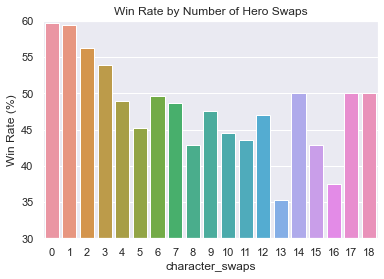

In [132]:
winrate_percent = sns.barplot(
    data = winrate_size,
    x = "character_swaps",
    y = "winrate",
   
)
winrate_percent.set_title("Win Rate by Number of Hero Swaps")
winrate_percent.set_ylabel("Win Rate (%)")
sns.set_style("darkgrid")
plt.ylim(30,60)
winrate_percent.figure.savefig("plots/winrate_by_swaps.png", dpi = 300)
plt.show()

In [133]:
winrate_size["total_games"] = winrate_size["num_wins"] + winrate_size["num_losses"] 
winrate_size

,comp_size,num_wins,num_losses,winrate,character_swaps,total_games
0,6,150,101,59.760956,0,251
1,7,259,177,59.403670,1,436
2,8,397,309,56.232295,2,706
3,9,414,355,53.836151,3,769
4,10,401,418,48.962149,4,819
5,11,340,412,45.212766,5,752
6,12,362,368,49.589041,6,730
7,13,311,328,48.669797,7,639
8,14,216,288,42.857143,8,504
9,15,155,171,47.546012,9,326


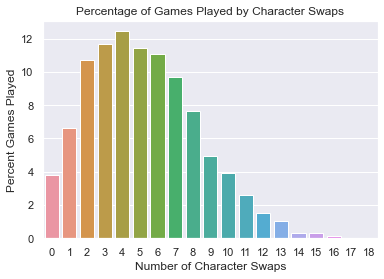

In [134]:
winrate_size["percent_games_played"] = winrate_size["total_games"] / winrate_size["total_games"].sum() * 100
games_by_numsize_percent = sns.barplot(
    data = winrate_size,
    x = "character_swaps",
    y = "percent_games_played"
)
games_by_numsize_percent.set_title("Percentage of Games Played by Character Swaps")
games_by_numsize_percent.set_ylabel("Percent Games Played")
games_by_numsize_percent.set_xlabel("Number of Character Swaps")
games_by_numsize_percent.figure.savefig("plots/games_played_char_swaps.png", dpi = 300)
plt.show()

## Encode with MultiLabelBinarizer

In [135]:
targetVectors.to_csv("filteredData/comps.csv", index = False)
df = load("dataframes/double.joblib")
df

,match_id,team1_comp,team2_comp,match_win,map_win
0,10223,"[D.Va, Genji, Mercy, Tracer, Widowmaker, Winst...","[D.Va, Genji, Junkrat, McCree, Mercy, Tracer, ...",win,win
1,10223,"[D.Va, Genji, Junkrat, McCree, Mercy, Tracer, ...","[D.Va, Genji, Mercy, Tracer, Widowmaker, Winst...",lose,lose
2,10223,"[D.Va, Genji, Lúcio, McCree, Mercy, Pharah, So...","[D.Va, Lúcio, McCree, Mercy, Pharah, Soldier: ...",win,win
3,10223,"[D.Va, Lúcio, McCree, Mercy, Pharah, Soldier: ...","[D.Va, Genji, Lúcio, McCree, Mercy, Pharah, So...",lose,lose
4,10223,"[Bastion, D.Va, Lúcio, Mercy, Soldier: 76, Tra...","[Ana, D.Va, Genji, McCree, Mercy, Soldier: 76,...",win,win
...,...,...,...,...,...
6577,35553,"[Ana, Ashe, Hanzo, Lúcio, Mercy, Roadhog, Sigm...","[Ana, Ashe, D.Va, Hanzo, Mercy, Pharah, Reinha...",win,lose
6578,35554,"[Ashe, D.Va, Lúcio, Mercy, Sigma, Symmetra, Tr...","[Ana, Ashe, Mercy, Roadhog, Sigma, Sombra, Sym...",lose,lose
6579,35554,"[Ana, Ashe, Mercy, Roadhog, Sigma, Sombra, Sym...","[Ashe, D.Va, Lúcio, Mercy, Sigma, Symmetra, Tr...",win,win
6580,35554,"[Ana, Hanzo, Lúcio, Mercy, Moira, Roadhog, Sig...","[Ana, Hanzo, Lúcio, Mercy, Roadhog, Sigma, Sym...",lose,lose


In [136]:
# Loads the MLB,
# Pops "team1_comp" out of the DF,
# fits and transforms the MLB on the "team1_comp" column
# and appends it back to the original DF with the new columns as the classes from the MLB

mlb = MultiLabelBinarizer()
df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('team1_comp')), columns = mlb.classes_, index=df.index))

In [137]:
# Transforms "team2_comp" in the way stated above based on the fit from team1
# Suffix is added to differntiate team1 from team2 in DF hero columns

df = df.join(pd.DataFrame(mlb.transform(df.pop('team2_comp')), columns = mlb.classes_, index=df.index), rsuffix= '_2')

In [138]:
df.to_csv("filteredData/MultiLabelBinarizer.csv", index  = False)
dump(df, "dataframes/mlb_DF.joblib")
df

,match_id,match_win,map_win,Ana,Ashe,Baptiste,Bastion,Brigitte,D.Va,Doomfist,...,Soldier: 76_2,Sombra_2,Symmetra_2,Torbjörn_2,Tracer_2,Widowmaker_2,Winston_2,Wrecking Ball_2,Zarya_2,Zenyatta_2
0,10223,win,win,0,0,0,0,0,1,0,...,0,0,0,0,1,0,1,0,0,1
1,10223,lose,lose,0,0,0,0,0,1,0,...,0,0,0,0,1,1,1,0,0,1
2,10223,win,win,0,0,0,0,0,1,0,...,1,0,0,0,1,1,1,0,0,1
3,10223,lose,lose,0,0,0,0,0,1,0,...,1,0,0,0,1,1,1,0,0,1
4,10223,win,win,0,0,0,1,0,1,0,...,1,0,0,0,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6577,35553,win,lose,1,1,0,0,0,0,0,...,0,0,0,0,1,1,0,1,0,0
6578,35554,lose,lose,0,1,0,0,0,1,0,...,0,1,1,0,0,1,0,1,0,0
6579,35554,win,win,1,1,0,0,0,0,0,...,0,0,1,0,1,1,0,1,0,1
6580,35554,lose,lose,1,0,0,0,0,0,0,...,0,0,1,0,1,1,0,1,0,0


In [139]:
dump(mlb, "models/mlb.joblib")

['models/mlb.joblib']

In [140]:
map_wins_by_char = load("dataframes/mlb_DF.joblib")
map_wins_by_char = map_wins_by_char[map_wins_by_char["map_win"] == "win"]
map_wins_by_char = map_wins_by_char.groupby(["map_win"]).mean()

In [141]:
map_wins_by_char = map_wins_by_char.iloc[:, 0:32]

In [142]:
percents = map_wins_by_char.multiply(100, axis = 0)

In [143]:
percents

,Ana,Ashe,Baptiste,Bastion,Brigitte,D.Va,Doomfist,Echo,Genji,Hanzo,...,Soldier: 76,Sombra,Symmetra,Torbjörn,Tracer,Widowmaker,Winston,Wrecking Ball,Zarya,Zenyatta
map_win,,,,,,,,,,,,,,,,,,,,,
win,43.677812,15.349544,29.787234,5.531915,41.550152,75.744681,25.288754,5.683891,31.155015,26.990881,...,16.534954,37.082067,19.544073,4.012158,61.428571,54.285714,58.632219,36.990881,31.793313,66.778116


Text(0.5, 0, 'Hero')

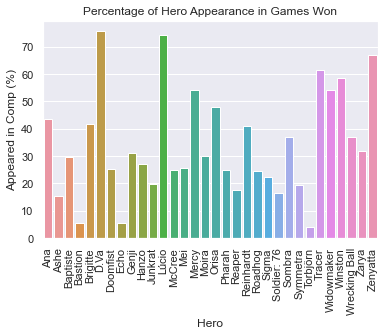

In [144]:
#Plots the character usage for winning team compositions only
character_wins = sns.barplot(
    data = percents
)
character_wins.set_title("Percentage of Hero Appearance in Games Won")
character_wins.set_xticklabels(character_wins.get_xticklabels(), rotation = 90)
character_wins.set_ylabel("Appeared in Comp (%)")
character_wins.set_xlabel("Hero")

In [145]:
character_wins.figure.savefig("plots/games_won_by_hero.png", bbox_inches = "tight", dpi = 300)
plt.show()

In [146]:
#MLB for maps included
df2 = load("dataframes/double_maps.joblib")
df2 = df2.values.tolist()
df2[0]

[10223,
 'Dorado',
 ['D.Va', 'Genji', 'Mercy', 'Tracer', 'Widowmaker', 'Winston', 'Zenyatta'],
 ['D.Va',
  'Genji',
  'Junkrat',
  'McCree',
  'Mercy',
  'Tracer',
  'Winston',
  'Zenyatta'],
 'win',
 'win']

In [147]:
teams_with_map = pd.DataFrame(columns = ["team1", "team2", "map_result"])
teams_with_map

,team1,team2,map_result


In [148]:
# Puts the map in with the team compisition list in order to be fit the same way on the MLB

for i in range(len(df2)):
    row = df2[i]

    map_name = [row[1]]
    team1 = row[2]
    team2 = row[3]
    map_result = row[5]

    newComp1 = map_name + team1
    newComp2 = map_name + team2

    vect = {"team1" : newComp1, "team2": newComp2, "map_result": map_result }
    teams_with_map = teams_with_map.append(vect, ignore_index = True)

teams_with_map

,team1,team2,map_result
0,"[Dorado, D.Va, Genji, Mercy, Tracer, Widowmake...","[Dorado, D.Va, Genji, Junkrat, McCree, Mercy, ...",win
1,"[Dorado, D.Va, Genji, Junkrat, McCree, Mercy, ...","[Dorado, D.Va, Genji, Mercy, Tracer, Widowmake...",lose
2,"[Ilios, D.Va, Genji, Lúcio, McCree, Mercy, Pha...","[Ilios, D.Va, Lúcio, McCree, Mercy, Pharah, So...",win
3,"[Ilios, D.Va, Lúcio, McCree, Mercy, Pharah, So...","[Ilios, D.Va, Genji, Lúcio, McCree, Mercy, Pha...",lose
4,"[Numbani, Bastion, D.Va, Lúcio, Mercy, Soldier...","[Numbani, Ana, D.Va, Genji, McCree, Mercy, Sol...",win
...,...,...,...
6577,"[Volskaya Industries, Ana, Ashe, Hanzo, Lúcio,...","[Volskaya Industries, Ana, Ashe, D.Va, Hanzo, ...",lose
6578,"[Busan, Ashe, D.Va, Lúcio, Mercy, Sigma, Symme...","[Busan, Ana, Ashe, Mercy, Roadhog, Sigma, Somb...",lose
6579,"[Busan, Ana, Ashe, Mercy, Roadhog, Sigma, Somb...","[Busan, Ashe, D.Va, Lúcio, Mercy, Sigma, Symme...",win
6580,"[King's Row, Ana, Hanzo, Lúcio, Mercy, Moira, ...","[King's Row, Ana, Hanzo, Lúcio, Mercy, Roadhog...",lose


In [149]:
mlb2 = MultiLabelBinarizer()
teams_with_map = teams_with_map.join(pd.DataFrame(mlb2.fit_transform(teams_with_map.pop('team1')), columns = mlb2.classes_, index=teams_with_map.index))

In [150]:
teams_with_map = teams_with_map.join(pd.DataFrame(mlb2.transform(teams_with_map.pop('team2')), columns = mlb2.classes_, index=teams_with_map.index), rsuffix= '_2')
teams_with_map

,map_result,Ana,Ashe,Baptiste,Bastion,Blizzard World,Brigitte,Busan,D.Va,Doomfist,...,Temple of Anubis_2,Torbjörn_2,Tracer_2,Volskaya Industries_2,Watchpoint: Gibraltar_2,Widowmaker_2,Winston_2,Wrecking Ball_2,Zarya_2,Zenyatta_2
0,win,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,1
1,lose,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,1,1,0,0,1
2,win,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,1,1,0,0,1
3,lose,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,1,1,0,0,1
4,win,0,0,0,1,0,0,0,1,0,...,0,0,1,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6577,lose,1,1,0,0,0,0,0,0,0,...,0,0,1,1,0,1,0,1,0,0
6578,lose,0,1,0,0,0,0,1,1,0,...,0,0,0,0,0,1,0,1,0,0
6579,win,1,1,0,0,0,0,1,0,0,...,0,0,1,0,0,1,0,1,0,1
6580,lose,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0


In [151]:
dump(mlb2, "models/mlb-map.joblib")

['models/mlb-map.joblib']

In [152]:
teams_with_map.to_csv("filteredData/MultiLabelBinarizer2.csv", index  = False)